In [44]:
import xarray as xr
import rasterio
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
from scipy.ndimage import gaussian_filter
from PIL import Image

In [2]:
colors =  [
    (0, '#d00602'),    # 0
    (0.2, '#fa0502'),    # 5
    (0.4, '#fbfd06'),    # 10
    (0.6, '#01fd08'),    # 15
    (0.8, '#04fef4'),    # 20
    (1, '#09dde0'),    # 25
]

In [3]:
depth_values = np.linspace(0, 25, len(colors))

In [4]:
colorscale = LinearSegmentedColormap.from_list('depth_scale', [c[1] for c in colors])

In [5]:
#d00602 0
#fa0502 5
#fbfd06 10
#01fd08 15
#04fef4 20
#09dde0 25

In [6]:
df = pd.read_csv('varna_rgb.csv')

In [7]:
df

,id,left,top,right,bottom,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4
0,1,27.646003,43.210982,27.647003,43.211482,NaN,NaN,NaN,NaN
1,2,27.646003,43.210482,27.647003,43.210982,NaN,NaN,NaN,NaN
2,3,27.646003,43.209982,27.647003,43.210482,NaN,NaN,NaN,NaN
3,4,27.646003,43.209482,27.647003,43.209982,NaN,NaN,NaN,NaN
4,5,27.646003,43.208982,27.647003,43.209482,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16165,16166,27.890003,43.180482,27.891003,43.180982,NaN,NaN,NaN,NaN
16166,16167,27.890003,43.179982,27.891003,43.180482,NaN,NaN,NaN,NaN
16167,16168,27.890003,43.179482,27.891003,43.179982,NaN,NaN,NaN,NaN
16168,16169,27.890003,43.178982,27.891003,43.179482,NaN,NaN,NaN,NaN


In [8]:
# Number of samples (choose as needed)
num_samples = 256
sampled_colors = np.array([colorscale(i / (num_samples - 1)) for i in range(num_samples)])
# Convert RGBA to RGB
rgb_colors = sampled_colors[:, :3]

In [9]:
rgb_colors[-2]

array([0.03490965, 0.86920415, 0.87996924])

In [10]:
# Define a function to map colors to depth using the colorscale
def color_to_depth(rgb):
    depth = griddata(rgb_colors, np.linspace(0,25,256), rgb, method='nearest')
    return depth

In [11]:
df1 = df.dropna()

In [121]:
df1

,id,left,top,right,bottom,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4,depth
110,111,27.647003,43.188982,27.648003,43.189482,175.0,37.0,1.0,255.0,10.0
111,112,27.647003,43.188482,27.648003,43.188982,184.0,24.0,8.0,255.0,10.0
116,117,27.647003,43.185982,27.648003,43.186482,145.0,50.0,56.0,255.0,10.0
117,118,27.647003,43.185482,27.648003,43.185982,138.0,60.0,56.0,255.0,10.0
175,176,27.648003,43.189482,27.649003,43.189982,204.0,149.0,32.0,255.0,10.0
...,...,...,...,...,...,...,...,...,...,...
16119,16120,27.890003,43.203482,27.891003,43.203982,171.0,19.0,14.0,255.0,10.0
16120,16121,27.890003,43.202982,27.891003,43.203482,175.0,6.0,9.0,255.0,10.0
16121,16122,27.890003,43.202482,27.891003,43.202982,217.0,9.0,7.0,255.0,10.0
16123,16124,27.890003,43.201482,27.891003,43.201982,211.0,110.0,20.0,255.0,10.0


In [12]:
rgb_varna = df1[['SAMPLE_1', 'SAMPLE_2', 'SAMPLE_3']].to_numpy()

In [13]:
rgb_varna[600]

array([238., 205.,  38.])

In [14]:
color_to_depth(rgb_varna)

array([10., 10., 10., ..., 10., 10., 10.])

In [15]:
depth = color_to_depth(rgb_varna)

In [16]:
depth.max()

20.0

In [17]:
df1['depth'] = depth

C:\Users\ABE\AppData\Local\Temp\ipykernel_25512\166878122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['depth'] = depth


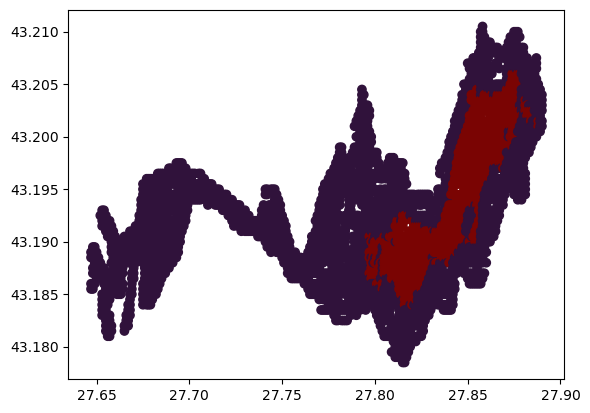

In [18]:
plt.scatter(df1['left'], df1['top'], c=df1['depth'], cmap='turbo')

In [19]:
# Read the georeferenced image
with rasterio.open('Varna_georef_clipped.tiff') as src:
    image = src.read()
    profile = src.profile

# Get dimensions
height, width = image.shape[1], image.shape[2]

# Initialize the depth map
depth_map = np.empty((height, width))

# Process each pixel to convert RGB to depth
for y in range(height):
    for x in range(width):
        pixel = image[:, y, x][:3]
        if sum(pixel) > 240*3:
            continue
        depth = color_to_depth(pixel)
        depth_map[y, x] = depth
    print(y)

C:\Users\ABE\AppData\Local\Temp\ipykernel_25512\1863388123.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  depth_map[y, x] = depth


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


In [20]:
depth_map.max()

20.0

In [21]:
depth_map_smooth = gaussian_filter(-np.flip(depth_map, 0), (5,5))

In [22]:
depth_map_smooth[depth_map_smooth > -1] = 0

In [50]:
depth_map_reduced = depth_map_smooth[::-3,::8]

In [53]:
depth_map_extended = np.hstack([depth_map_reduced, np.zeros((depth_map_reduced.shape[0], 30))])

In [55]:
depth_map_extended.shape

(42, 149)

In [56]:
depth_map_reduced.shape

(42, 119)

In [57]:
im = Image.fromarray(depth_map_extended)
im.save("Varna_bathymetry.tiff")

In [41]:
?scipy.misc.toimage()

Object `scipy.misc.toimage()` not found.


In [31]:
12.5/60

0.20833333333333334

In [32]:
lons = np.linspace(27.6, 27.9, depth_map_reduced.shape[1])
lats = np.linspace(43.18, 43.2, depth_map_reduced.shape[0])

In [33]:
lonm, latm = np.meshgrid(lons, lats)

In [35]:
lonm.shape

(42, 119)

In [36]:
df_out = pd.DataFrame({'lon': lonm.ravel(), 'lat': latm.ravel(), 'depth': depth_map_reduced.ravel()})

In [38]:
df_out.to_csv('Varna_topo_coords.csv')

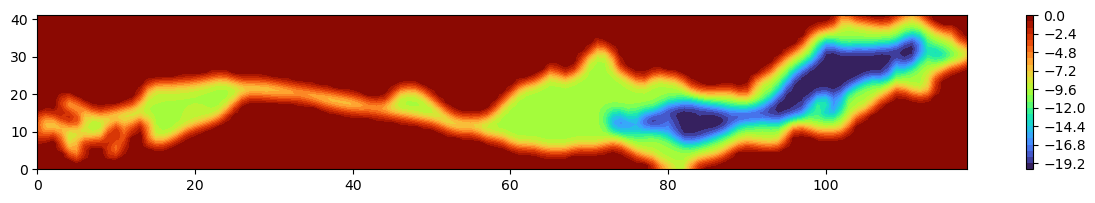

In [188]:
fig, ax = plt.subplots(figsize=(15,2))
plt.contourf(depth_map_smooth[::3,::8], cmap='turbo', levels=30)
plt.colorbar()
plt.savefig('Varna_bathymetry_raw.png', dpi=200)

In [ ]:
fig, ax = plt.subplots(figsize=(15,2))
plt.contourf(depth_map_smooth[::3,::8], cmap='turbo', levels=30)
plt.colorbar()
plt.savefig('Varna_bathymetry_raw.png', dpi=200)

In [189]:
np.savetxt('Varna_topo_smooth.txt', depth_map_smooth[::3,::8], fmt='%.4f')